In [1]:
import matplotlib.pyplot as plt
import modred as mr
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader

from src.models import MLP
from src.solvers.fem import HelmholtzImpedance, FEMSolver, ParameterizedSource
from src.utils.helpers import PairDataset

In [2]:
sns.set_theme()

In [3]:
def get_solution(u, bases):
    assert len(u) == len(bases)
    return lambda x: np.sum([u[i] * bases[i](x) for i in range(len(bases))], axis=0)

In [4]:
def plot_bases(S, bases):

    xs = np.linspace(-1, 1, 100)
    us = []
    # MODIFY: Combine these two loops
    sols = [get_solution(S[:, j], bases) for j in range(S.shape[1])]
    for idx, sol in enumerate(sols):
        us.append(sol(xs))

    df = pd.DataFrame({
        'x': np.concatenate([xs] * len(us)),
        'u_re': np.concatenate([u.real for u in us]),
        'u_im': np.concatenate([u.imag for u in us]),
        'j': np.concatenate([np.repeat(j, len(xs)) for j in range(len(sols))]),
    })

    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 10))
    sns.lineplot(
        data=df,
        x='x',
        y='u_re',
        hue='j',
        ax=axs[0],
    )
    sns.lineplot(
        data=df,
        x='x',
        y='u_im',
        hue='j',
        ax=axs[1],
    )


# Get N solutions with random parameters

In [5]:
N_h = 201
N_bas = 20
N_trn = 300
N_val = 50

f = [
    lambda x: 30,
    lambda x: 3 * x,
    lambda x: 20 * (x ** 4),
    lambda x: 10 * np.exp(x),
    lambda x: 10 * np.exp(3 * (x ** 2)),
    lambda x: 10 * np.exp(-5 * x),
    lambda x: 15 * np.sin(x),
    lambda x: -10 * np.cos(3 * x),
]

solver = HelmholtzImpedance(
    f=None,
    k=(8. * (np.pi / 2)),
    a=-1.,
    b=+1.,
    ga=10.,
    gb=20.,
    source='func',
    N=(N_h-1),
    # N_quad=100,
)
npar = ParameterizedSource(solver=solver, f=f)
S_bas = npar.solve(y=np.random.random_sample(size=(len(f), N_bas)))
print(f'rank(S): {np.linalg.matrix_rank(S_bas)}')

/Users/sepehr/miniconda3/envs/mcss/lib/python3.10/site-packages/scipy/special/_orthogonal.py:370: RuntimeWarning: invalid value encountered in double_scalars
  hn *= _gam(n + beta + 1.0) / _gam(n + 1) / _gam(n + ab1)
/Users/sepehr/miniconda3/envs/mcss/lib/python3.10/site-packages/scipy/special/_orthogonal.py:371: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + ab1) / 2.0**n / _gam(n + 1) / _gam(n + ab1)
/Users/sepehr/miniconda3/envs/mcss/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


rank(S): 9


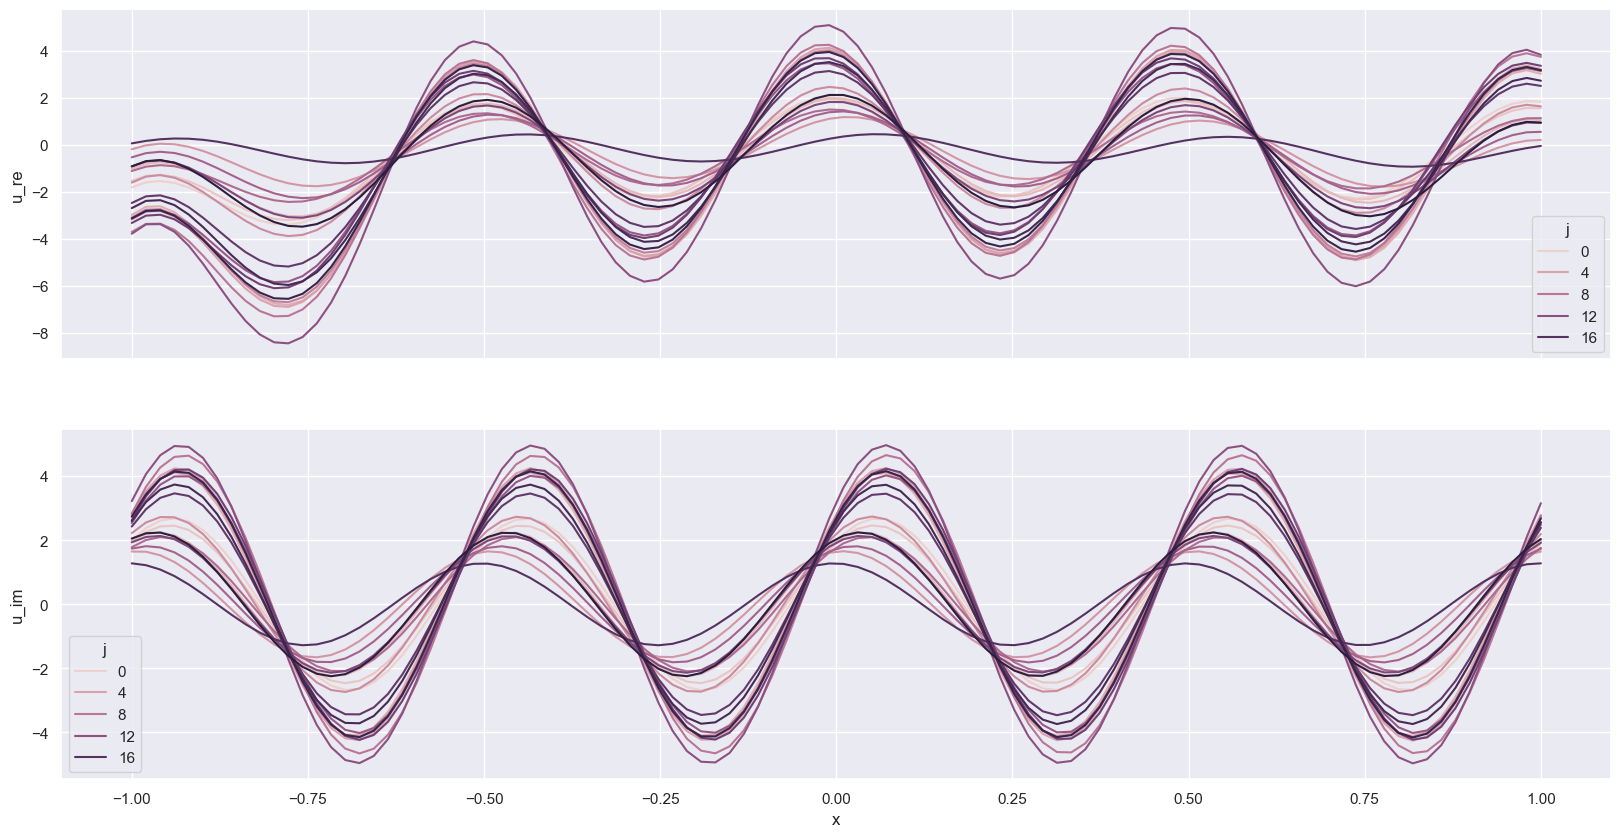

In [6]:
plot_bases(S=S_bas, bases=solver.bases)

# Get reduced basis functions

2.3240467869142196
[4.84901159e+04 8.68468489e+02 2.65552811e+01 2.25680191e+00
 4.61981606e-01 1.74091272e-01 1.65772886e-03]


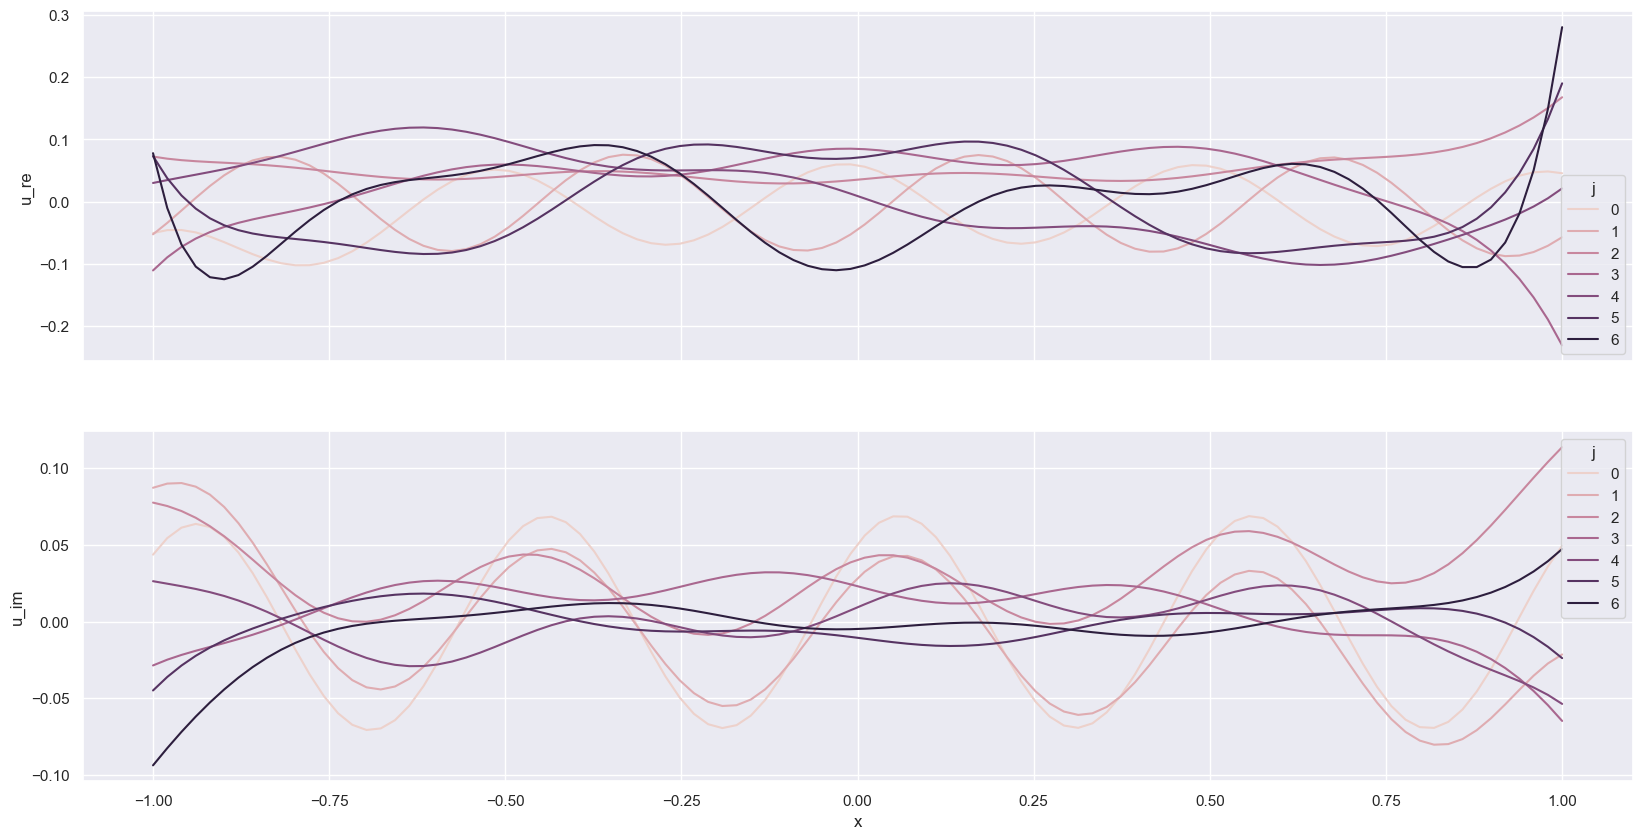

In [7]:
L = 7

assert L <= np.linalg.matrix_rank(S_bas)
pod = mr.compute_POD_arrays_snaps_method(
    S_bas,
    list(mr.range(L))
)
V = pod.modes

# CHECK: Is it okay? If not, I need to implement POD
print(np.linalg.norm(V.T @ V - np.identity(V.shape[1])))

print(pod.eigvals[:L])

plot_bases(S=V, bases=solver.bases)


# Generate train and validation data

In [8]:
y_trn = np.random.random_sample(size=(len(f), N_trn))
S_trn = npar.solve(y=y_trn)
c_trn = V.T @ S_trn

/Users/sepehr/miniconda3/envs/mcss/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [9]:
y_val = np.random.random_sample(size=(len(f), N_val))
S_val = npar.solve(y=y_val)
c_val = V.T @ S_val

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$')]

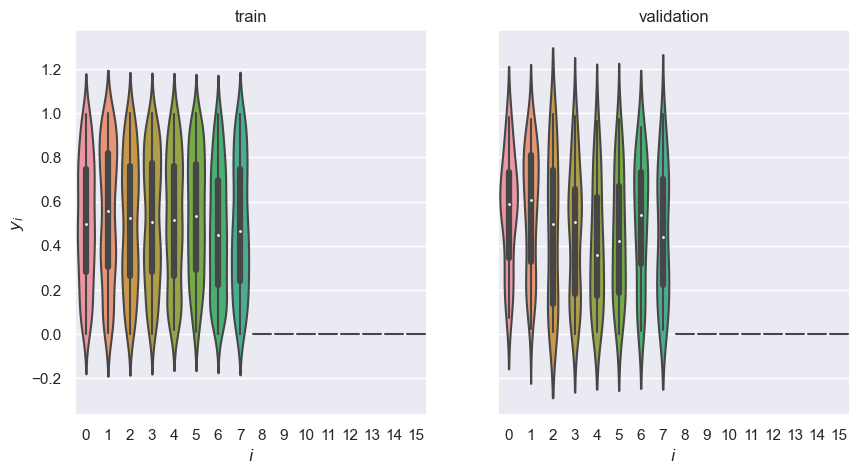

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.violinplot(pd.DataFrame(np.concatenate([y_trn.real, y_trn.imag]).T), ax=axs[0])
sns.violinplot(pd.DataFrame(np.concatenate([y_val.real, y_val.imag]).T), ax=axs[1])
axs[0].set(title='train', xlabel='$i$', ylabel='$y_i$')
axs[1].set(title='validation', xlabel='$i$')

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$')]

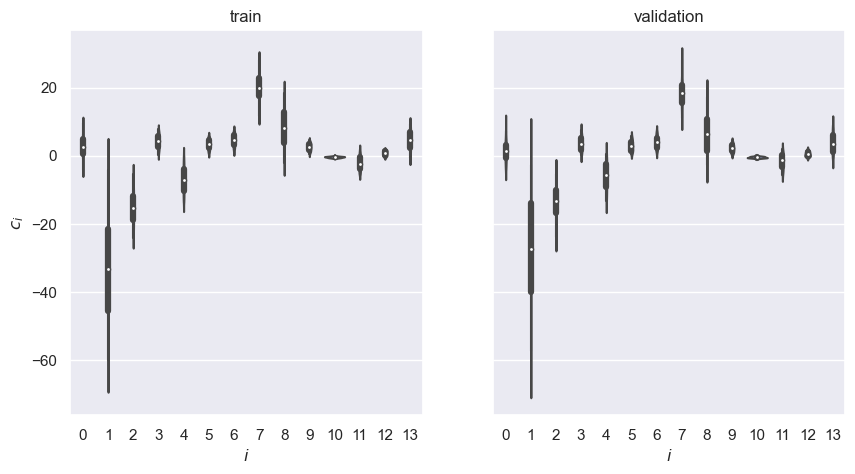

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.violinplot(pd.DataFrame(np.concatenate([c_trn.real, c_trn.imag]).T), ax=axs[0])
sns.violinplot(pd.DataFrame(np.concatenate([c_val.real, c_val.imag]).T), ax=axs[1])
axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
axs[1].set(title='validation', xlabel='$i$')

# Train a model

In [22]:
epochs = 1000
lr = 1e-03
report = 1000
bsz = None
batch_norm = True

if batch_norm and bsz:
    assert bsz > 1

# Define data loaders
trainloader = DataLoader(
    dataset=PairDataset(y=y_trn, c=c_trn),
    batch_size=(bsz if bsz else y_trn.shape[1]),
    shuffle=True,
    drop_last=batch_norm,
)
validationloader = DataLoader(
    dataset=PairDataset(y=y_val, c=c_val),
    batch_size=1,
    shuffle=False,
)

# Define model, criterion, and optimizer
model = MLP(
    M=len(f),
    L=(2 * L),  # Reald and imaginary parts
    hidden_layers=[20, 20],
    activation=torch.sigmoid,
    dtype=torch.float64,
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epochs)

# Train the model
print(f'{model.__class__.__name__} with {model.numparams()} parameters')
stats = model.train_(
    criterion=criterion,
    epochs=epochs,
    optimizer=optimizer,
    trainloader=trainloader,
    validationloader=validationloader,
    scheduler=scheduler,
    cuda=False,
    # report=report,
)

MLP with 1002 parameters


In [23]:
params = stats.pop('params')
grads = stats.pop('grads')
for key in params:
    params[key] = [val.detach().numpy() for val in params[key]if val is not None]
    grads[key] = [val.detach().numpy() for val in grads[key] if val is not None]
stats = pd.DataFrame(stats)

[None]

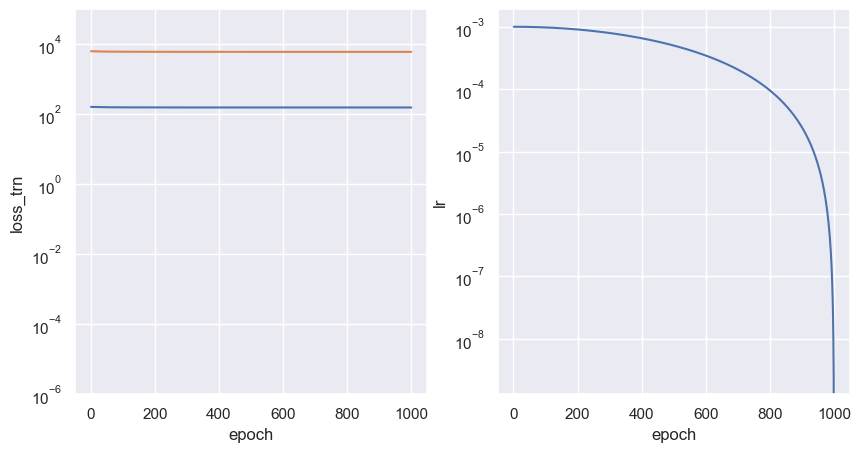

In [24]:
# Plot the training statistics
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(stats, x='epoch', y='loss_trn', ax=axs[0])
sns.lineplot(stats, x='epoch', y='loss_val', ax=axs[0])
axs[0].set(yscale='log', ylim=[1e-06, 1e05])
sns.lineplot(stats, x='epoch', y='lr', ax=axs[1])
axs[1].set(yscale='log')

In [25]:
params_ = {}
grads_ = {}
for name, vals in params.items():
    if not model.bn and 'bn' in name:
        continue
    params_[name] = {'epoch': [], 'val': []}
    for e in range(len(stats['epoch'])):
        val = vals[e].flatten()
        params_[name]['epoch'].extend([e] * len(val))
        params_[name]['val'].extend(val)
for name, vals in grads.items():
    if not model.bn and 'bn' in name:
        continue
    grads_[name] = {'epoch': [], 'val': []}
    for e in range(len(stats['epoch'])-1):
        val = vals[e].flatten()
        grads_[name]['epoch'].extend([e] * len(val))
        grads_[name]['val'].extend(val)
params = {name: pd.DataFrame(params_[name]) for name in params_.keys()}
grads = {name: pd.DataFrame(grads_[name]) for name in grads_.keys()}

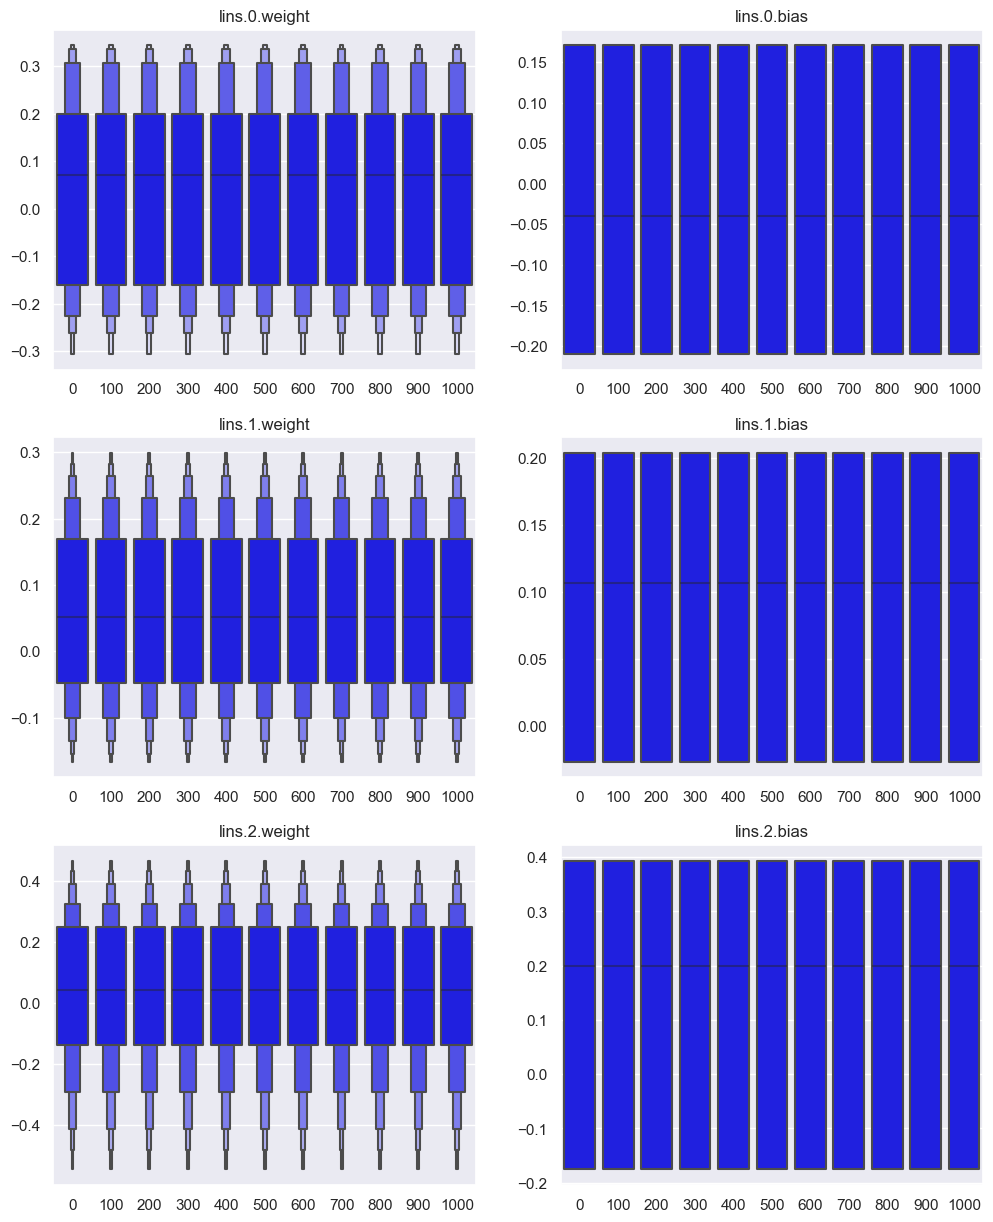

In [27]:
ncols = 2
nrows = (len(params) + 1) // ncols
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(12, 5 * nrows)
)
axs = axs.flatten()

for idx, (name, df) in enumerate(params.items()):
    sns.boxenplot(
        data=df[(df['epoch'] % 100 == 0)],
        x='epoch', y='val',
        color='blue',
        showfliers=False,
        ax=axs[idx],
    )

    axs[idx].set(ylabel='', xlabel='', title=name)

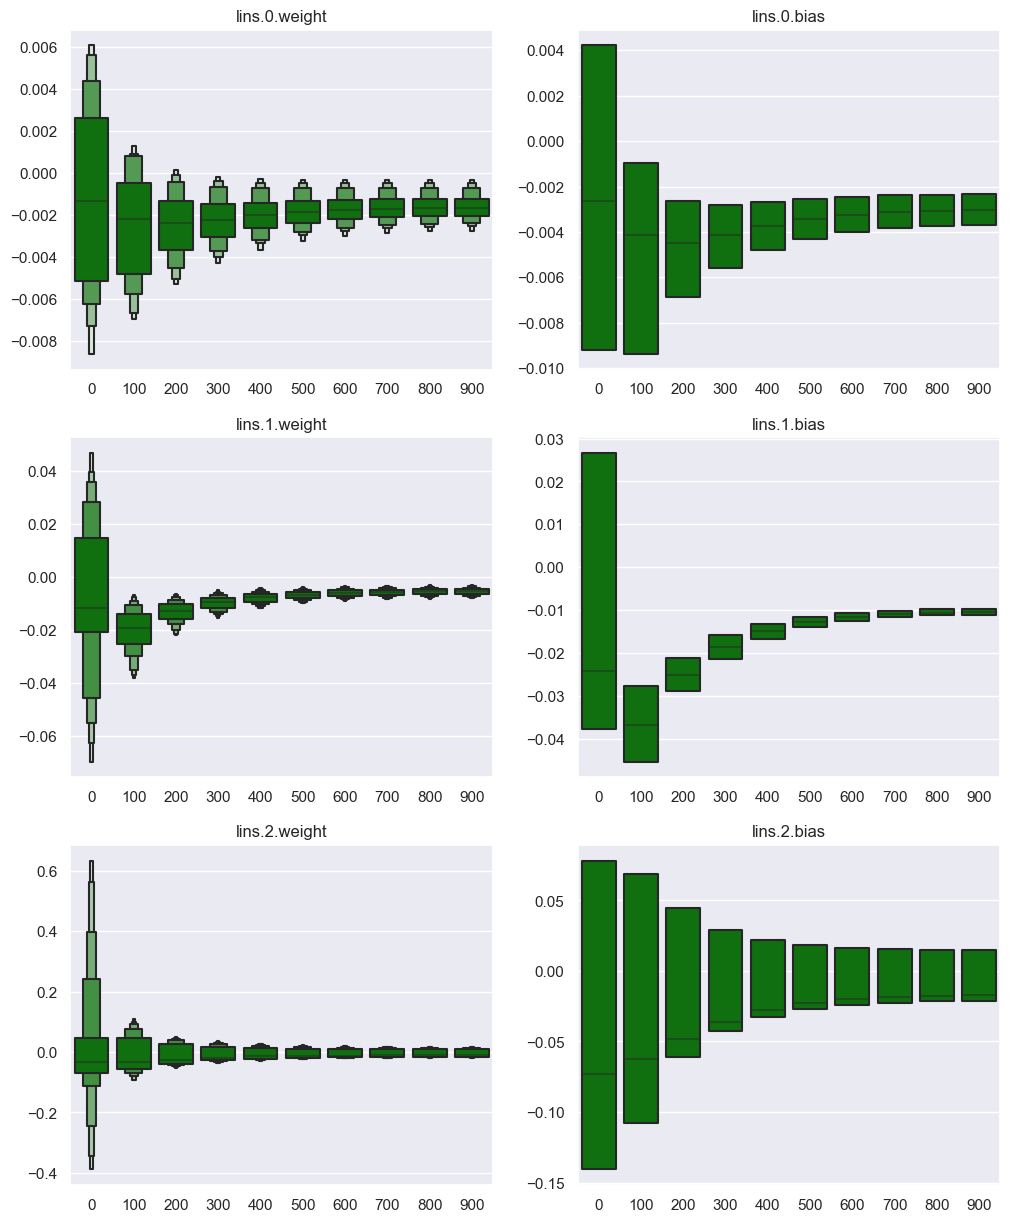

In [28]:
ncols = 2
nrows = (len(grads) + 1) // ncols
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(12, 5 * nrows)
)
axs = axs.flatten()

for idx, (name, df) in enumerate(grads.items()):
    sns.boxenplot(
        data=df[(df['epoch'] % 100 == 0)],
        x='epoch', y='val',
        color='green',
        showfliers=False,
        ax=axs[idx],
    )

    axs[idx].set(ylabel='', xlabel='', title=name)